# Bank Classification

### By: Brian Rafferty

I will be using a FDIC bulk data, https://cdr.ffiec.gov/public/PWS/DownloadBulkData.aspx, to create a classification ML model to learn how to group US financial institutions by Peer Group.
* Peer Group - a group of banks that share characteristics such as size and economic environment

With a model that is trained to use KPIs to designate a Peer Groups, one can:
* Classify banks beyond the US FDIC dataset to produce data driven business strategies. 
* Determine the overall health of a financial institution compared to its peers. 
* Analyze trends on services rendered by similar banks.

Additional FDIC bulk data information can be found in the User’s Guide for the Uniform Bank Performance Report – Technical Information: https://cdr.ffiec.gov/CDRDownload/CDR/UserGuide/v105/Technical%20Information.pdf

#### 1. Import Libraries

In [1]:
# Dataframes
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Math libraries
import math
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Scaling
from sklearn.preprocessing import QuantileTransformer

# ML Tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE

# ML Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# ML Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.metrics import accuracy_score

#### 2. Collect Data
* After downloading all the data from the FDIC link and studying its associated documentation, it is time to get started
* The challenge will now be to see if there is enough evidence in the dataset to create a classification model that accurately predicts the Peer Group of each bank

In [2]:
# Start by reading in the Ratios Summary text file
# Note: This file does not contain Peer Group, the target variable, 
#       but it may have useful data for predicting it.      
ratio_df = pd.read_csv(r".\input\FFIEC CDR Bulk All UBPR Ratios 2021\FFIEC CDR UBPR Ratios Summary Ratios 2021.txt", sep='\t', header=(0))
print(ratio_df.shape)
ratio_df.head()

(10027, 47)


,Reporting Period,ID RSSD,UBPR3210,UBPR4340,UBPR7316,UBPR7402,UBPR7408,UBPR7414,UBPRD486,UBPRD488,UBPRD659,UBPRE001,UBPRE002,UBPRE003,UBPRE004,UBPRE005,UBPRE006,UBPRE007,UBPRE008,UBPRE009,UBPRE010,UBPRE011,UBPRE012,UBPRE013,UBPRE014,UBPRE015,UBPRE016,UBPRE017,UBPRE018,UBPRE019,UBPRE020,UBPRE021,UBPRE022,UBPRE023,UBPRE024,UBPRE025,UBPRE026,UBPRE027,UBPRE028,UBPRE029,UBPRE541,UBPRE542,UBPRJ248,UBPRJA35,UBPRK447,UBPRKW07,Unnamed: 46
0,NaN,NaN,TOTAL EQUITY CAPITAL,NET INCOME,SURVEILLANCE MODEL ASSET GROWTH RATE,TOTAL DIVIDENDS AS PERCENT OF NET IN,ANNUAL CHANGE IN TIER 1 CAPITAL,NONCURRENT ASSETS AS PERCENT OF TOTL,RBC_T1_TOT_AA,RBC_TOT_RWA,ASET_QAVG_CYA,INC_AA,INT_EXP_AA,INT_INC_NET_AA,INC_NONINT_AA,OVHD_EXP_AA,PROV_LNLS_ATTR_AA,INC_PTAX_OP_AA,SEC_GN_AA,INC_PTAX_NET_OP_AA,INC_NET_OP_AA,INC_BEI_AA,INC_NET_SUBS_AA,INC_NET_AA,EA_AVG_AA,LIAB_IB_AA,INT_INC_EA,INT_EXP_EA,INT_INC_NET_EA,NET_LNLS_AVG_CYB,NOI_LNLS_CHGFF_CYB,LNLS_LOS_NET,LNLS_LOS_NHFS,LNLS_LOS_TOT,LNLS_ASET_TOT,NI_DIVD_ECAP_CYB,LNLS_NINV_ORE_CAP,LNLS_NET_GY,INV_TEMP_GY,NCORE_FND_LT1_GY,LNLS_TOT_PD_90_GRS,LNLS_TOT_NACCR,INCNET_NONCON_AA,Unrealized holding gains (losses) on,NCORE DPDNCY INS LIMIT TIME DEP,Provision for credit losses on all o,NaN
1,3/31/2021 11:59:59 PM,37.0,16988,55,13.99,0,1.26,0.46,18.3717,NaN,88179,2.98,0.33,2.66,0.34,2.69,0,0.32,0,0.32,0.25,0.25,0.25,0.25,95.14,56.14,3.14,0.34,2.79,-0.02,NaN,NaN,4.56,4.56,23.11,1.27,0.99,-9.69,89.82,0.97,0.12,0.35,0,0,-11.67,NaN,NaN
2,3/31/2021 11:59:59 PM,242.0,5105,161,25.05,177.02,0.47,0.04,9.6071,NaN,52992,3.02,0.42,2.61,0.49,1.77,0,1.33,0,1.33,1.22,1.35,1.05,1.22,94.55,67.27,3.2,0.44,2.76,-0.28,NaN,NaN,0.71,0.71,44.96,-9.38,1.33,1.66,67.34,476.45,0.04,0,0,0,-10.61,NaN,NaN
3,3/31/2021 11:59:59 PM,279.0,31658,244,17.27,0,1.47,0.45,10.097,NaN,306887,3.42,0.73,2.69,0.48,2.77,0,0.4,0,0.4,0.32,0.32,0.32,0.32,94.59,78.66,3.62,0.77,2.84,0,295,390.5,0.73,0.73,67.08,3.09,5.09,16.54,87.01,-28.37,0,0.45,0,0,2.45,NaN,NaN
4,3/31/2021 11:59:59 PM,354.0,1653,0,30.16,NaN,14.39,0,8.7627,NaN,18864,3.73,0.28,3.46,0.87,4.33,0,0,0,0,0,0.04,0,0,97.13,45.9,3.84,0.28,3.56,-0.09,NaN,NaN,2.15,2,46.82,0,0,-22.85,312.13,1.56,0,0,0,0,-89.21,NaN,NaN


In [3]:
# Next, read in the Ranks Summary text file
# Note: This file contains the target variable, but 
#       contains relatively useless data otherwise.
rank_df = pd.read_csv(r".\input\FFIEC CDR Bulk All UBPR Ranks 2021\FFIEC CDR UBPR Ranks Summary Ratios 2021.txt", sep='\t', header=(0))
print(rank_df.shape)
rank_df.head()

(42112, 45)


C:\Users\Brian\anaconda3\envs\conda_env\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Reporting Period,ID RSSD,Peer Group,UBPK7316,UBPK7402,UBPK7408,UBPK7414,UBPKD486,UBPKD488,UBPKE001,UBPKE002,UBPKE003,UBPKE004,UBPKE005,UBPKE006,UBPKE007,UBPKE008,UBPKE009,UBPKE010,UBPKE011,UBPKE012,UBPKE013,UBPKE014,UBPKE015,UBPKE016,UBPKE017,UBPKE018,UBPKE019,UBPKE020,UBPKE021,UBPKE022,UBPKE023,UBPKE024,UBPKE025,UBPKE026,UBPKE027,UBPKE028,UBPKE029,UBPKJ248,UBPKJA35,UBPKK447,UBPKKW07,UBPKE541,UBPKE542,Unnamed: 44
0,NaN,NaN,NaN,SURVEILLANCE MODEL ASSET GROWTH RATE,TOTAL DIVIDENDS AS PERCENT OF NET IN,ANNUAL CHANGE IN TIER 1 CAPITAL,NONCURRENT ASSETS AS PERCENT OF TOTL,RBC_T1_TOT_AA,RBC_TOT_RWA,INC_AA,INT_EXP_AA,INT_INC_NET_AA,INC_NONINT_AA,OVHD_EXP_AA,PROV_LNLS_ATTR_AA,INC_PTAX_OP_AA,SEC_GN_AA,INC_PTAX_NET_OP_AA,INC_NET_OP_AA,INC_BEI_AA,INC_NET_SUBS_AA,INC_NET_AA,EA_AVG_AA,LIAB_IB_AA,INT_INC_EA,INT_EXP_EA,INT_INC_NET_EA,NET_LNLS_AVG_CYB,NOI_LNLS_CHGFF_CYB,LNLS_LOS_NET,LNLS_LOS_NHFS,LNLS_LOS_TOT,LNLS_ASET_TOT,NI_DIVD_ECAP_CYB,LNLS_NINV_ORE_CAP,LNLS_NET_GY,INV_TEMP_GY,NCORE_FND_LT1_GY,INCNET_NONCON_AA,Unrealized holding gains (losses) on,NCORE DPDNCY INS LIMIT TIME DEP,Provision for credit losses on all o,LNLS_TOT_PD_90_GRS,LNLS_TOT_NACCR,NaN
1,3/31/2021 11:59:59 PM,12311.0,1,56,76,13,40,66,36,90,3,93,40,66,53,90,10,83,90,90,90,90,60,53,86,3,93,60,56,52,70,70,80,36,80,80,96,40,90,76,63,39,63,43,NaN
2,3/31/2021 11:59:59 PM,35301.0,1,3,46,3,3,3,60,6,10,6,93,90,90,13,40,13,16,36,16,16,3,13,6,10,6,16,NaN,NaN,10,10,10,50,3,66,6,6,73,66,10,46,20,3,NaN
3,3/31/2021 11:59:59 PM,75633.0,1,53,46,70,73,80,50,53,83,50,26,26,60,40,60,43,40,56,40,40,63,66,53,83,53,26,88,92,30,30,53,63,63,40,56,13,73,80,33,NaN,33,76,NaN
4,3/31/2021 11:59:59 PM,112837.0,1,46,50,10,30,33,43,93,90,90,80,96,23,76,70,76,76,73,76,76,23,50,93,90,90,76,44,64,93,93,43,76,40,60,36,33,13,83,6,57,60,36,NaN


In [4]:
# Merge the target variable from rank with the ratio data, use 'ID RSSD' as the primary/foreign key relationship
merged_df = pd.merge(rank_df[['ID RSSD', 'Peer Group']], ratio_df, how='inner', on='ID RSSD')
merged_df.shape

(84082, 48)

In [5]:
# Lots of duplicates for each ID RSSD, keep the first occurrence of each ID only
df_cleaned = merged_df.drop_duplicates(subset='ID RSSD', keep="first")
df_cleaned.shape

(5031, 48)

In [6]:
# Lastly, read in CDR Call data, that contains over 200 columns describing the
# current state of each bank
banks_df = pd.read_csv(r".\input\FFIEC CDR Call Bulk Subset of Schedules 2021\FFIEC CDR Call Subset of Schedules 2021(1 of 2).txt", sep='\t', header=(0))
banks_df.head()

# Update the name of its ID to match the other dataframe
banks_df = banks_df.rename(columns={'IDRSSD': 'ID RSSD'})

C:\Users\Brian\anaconda3\envs\conda_env\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252) have mixed ty

In [7]:
# Merge the bank data to the other dataframe that contains the target variable
merged_df = pd.merge(banks_df, df_cleaned, how='inner', on='ID RSSD')

# Lots of duplicates for each 'ID RSSD', keep the first occurrence of each ID only
trimmed_df = merged_df.drop_duplicates(subset='ID RSSD', keep="first")
trimmed_df.head()

,Reporting Period End Date,ID RSSD,FDIC Certificate Number,OCC Charter Number,OTS Docket Number,Primary ABA Routing Number,Financial Institution Name,Financial Institution Address,Financial Institution City,Financial Institution State,Financial Institution Zip Code,Financial Institution Filing Type,Last Date/Time Submission Updated On,RCFD0071,RCFD0081,RCFD1248,RCFD1249,RCFD1250,RCFD1251,RCFD1252,RCFD1253,RCFD1254,RCFD1255,RCFD1256,RCFD1403,RCFD1406,RCFD1407,RCFD1583,RCFD1594,RCFD1597,RCFD1773,RCFD2130,RCFD2143,RCFD2145,RCFD2150,RCFD2160,RCFD2170,RCFD2930,RCFD2948,RCFD3000,RCFD3123,RCFD3190,RCFD3200,RCFD3210,RCFD3230,RCFD3300,RCFD3505,RCFD3506,RCFD3507,RCFD3529,RCFD3530,RCFD3545,RCFD3548,RCFD3632,RCFD3656,RCFD3838,RCFD3839,RCFD5369,RCFD5377,RCFD5378,RCFD5379,RCFD5380,RCFD5381,RCFD5382,RCFD5389,RCFD5390,RCFD5391,RCFD5459,RCFD5460,RCFD5461,RCFD6558,RCFD6559,RCFD6560,RCFD6724,RCFDA130,RCFDB528,RCFDB529,RCFDB530,RCFDB575,RCFDB576,RCFDB577,RCFDB989,RCFDB995,RCFDC226,RCFDC240,RCFDC241,RCFDC410,RCFDC411,RCFDF166,RCFDF167,RCFDF168,RCFDF169,RCFDF170,RCFDF171,RCFDG105,RCFDHK26,RCFDHK27,RCFDHK28,RCFDJA22,RCFDJJ34,RCFDK036,RCFDK037,RCFDK038,RCFDK039,RCFDK040,RCFDK041,RCFDK042,RCFDK043,RCFDK044,RCFDK087,RCFDK088,RCFDK089,RCFDK102,RCFDK103,RCFDK104,RCFDK120,RCFDK121,RCFDK122,RCFDK123,RCFDK124,RCFDK125,RCFDK126,RCFDK127,RCFDK128,RCFDK138,RCFDK139,RCFDK140,RCFDK213,RCFDK214,RCFDK215,RCFDK216,RCFDK217,RCFDK218,RCFDK274,RCFDK275,RCFDK276,RCFDK277,RCFDK278,RCFDK279,RCFDK280,RCFDK281,RCFDK282,RCFDL183,RCFDL184,RCFDL185,RCFDL186,RCFDL187,RCFDL188,RCFN2200,RCFN6631,RCFN6636,RCFNB572,RCFNB573,RCFNB574,RCON0071,RCON0081,RCON1226,RCON1227,RCON1228,RCON1248,RCON1249,RCON1250,RCON1254,RCON1255,RCON1256,RCON1403,RCON1406,RCON1407,RCON1583,RCON1594,RCON1597,RCON1606,RCON1607,RCON1608,RCON1773,RCON2130,RCON2143,RCON2145,RCON2150,RCON2160,RCON2170,RCON2200,RCON2930,RCON2948,RCON3000,RCON3123,RCON3190,RCON3200,RCON3210,RCON3230,RCON3300,RCON3493,RCON3494,RCON3495,RCON3499,RCON3500,RCON3501,RCON3505,RCON3506,RCON3507,RCON3545,RCON3548,RCON3632,RCON3656,RCON3838,RCON3839,RCON5369,RCON5380,RCON5381,RCON5382,RCON5398,RCON5399,RCON5400,RCON5459,RCON5460,RCON5461,RCON6558,RCON6559,RCON6560,RCON6631,RCON6636,RCON6724,RCON8678,RCONA130,RCONB528,RCONB529,RCONB530,RCONB575,RCONB576,RCONB577,RCONB834,RCONB835,RCONB836,RCONB987,RCONB989,RCONB993,RCONB995,RCONC226,RCONC229,RCONC230,RCONC236,RCONC237,RCONC238,RCONC239,RCONC240,RCONC241,RCONC410,RCONC411,RCONF166,RCONF167,RCONF168,RCONF172,RCONF173,Unnamed: 253,Peer Group,Reporting Period,UBPR3210,UBPR4340,UBPR7316,UBPR7402,UBPR7408,UBPR7414,UBPRD486,UBPRD488,UBPRD659,UBPRE001,UBPRE002,UBPRE003,UBPRE004,UBPRE005,UBPRE006,UBPRE007,UBPRE008,UBPRE009,UBPRE010,UBPRE011,UBPRE012,UBPRE013,UBPRE014,UBPRE015,UBPRE016,UBPRE017,UBPRE018,UBPRE019,UBPRE020,UBPRE021,UBPRE022,UBPRE023,UBPRE024,UBPRE025,UBPRE026,UBPRE027,UBPRE028,UBPRE029,UBPRE541,UBPRE542,UBPRJ248,UBPRJA35,UBPRK447,UBPRKW07,Unnamed: 46
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INT-BEARING BALS DUE FRM DEP INSTS,NONINTEREST-BEARING BALS&CURR&COIN,"LNS SECD BY RE TO NONUS ADR,PAS DU30","LNS SECD BY RE TO NONUS ADR,PAS DU90","LNS SECD BY RE TO NONUS ADR,NONACCRL","C&I LNS TO US ADDRS,PAS DU 30-89 DYS","C&I LNS TO US ADDRS,PAS DU 90 DYS OR","C&I LNS TO US ADDRS,NONACCRUAL","C&I LNS TO NONUS ADR,PAS DU 30-89 DY","C&I LNS TO NONUS ADR,PAS DU 90 DYS","C&I LNS TO NONUS ADR,NONACCRUAL","TOTAL, NONACCRUAL","TOTAL, PAST DUE 30-89 DAYS, ACCRUING","TOTAL, PAST DUE 90 OR MORE, ACCRUING","LOANS TO FARMERS, NONACCRUAL","LN TO FRMERS,PAST 30-89 DYS, ACCRUIN","LN TO FRMERS,PAST 90 OR MORE,ACCRUIN",AVAILABLE-FOR-SALE SECURITIES,INVEST. IN UNCONSOLIDATED SUBS & CO.,INTANGIBLE ASSETS,PREMISES&FIXED ASSETS(INCL CAP LSES),OTHER REAL ESTATE OWNED,OTHER ASSETS,TOTAL ASSETS,"OTHER LIABILITIES, TOTAL",TOTAL LIABILITIES,MINORITY INT. IN CONSOL. SUBSIDIARIE,ALLL_AMT,OTHER BORROWED MONEY,SUBORDINATED NOTES AND DEBENTURES,TOTAL EQUITY CAPITAL,COMMON STOCK,"TOT LIAB, RESERVE & CAPITAL ACCO

#### 3. Data Cleaning
* Before moving forward, the compiled dataset needs to be cleaned in the following ways:
    * Compress the two header rows into one, so each column has a single title
        * Notice the 14th column in the dataframe above
            * If there is a code (Ex. 'RCFD0071') present as a column header it will be replaced with the title located in the row beneath it (Ex. 'INT-BEARING BALS DUE FRM DEP INSTS')
    * Remove extra columns starting with "Unnamed" that resulted from the data collection process
    * Remove columns containing irrelevant data that originated in the CDR Call dataset
        * Irrelevant data includes: bank names, bank locations, routing numbers, timestamps, etc.
    * Remove duplicate columns from the dataset that resulted from the merging of dataframes
    * Set 'ID RSSD' as the index before splitting the data into feature and target dataframes 
    * Remove all columns containing missing data from the feature dataframe
    * Convert all remaining columns in the feature dataframe to numeric values

In [8]:
# Function to clean the merged dataframe, replacing original column headers: RCONC240 
# with the English titles stored in the first row: LNS & LEASES H-F-S PA DU 30-89 DYS
def clean_dataframe(dataframe):
    
    # Helper function to convert a list of tuples into a dictionary
    def convert_to_dict(list_of_tuples):
        header_dict = dict(list_of_tuples)
        return header_dict

    # Get the columns headers in a list
    original_headers = list(dataframe.columns)
    # Get the displaced titles from the first row in a list
    displaced_headers = list(dataframe.iloc[0])
    # Zip the lists into a list of tuples to preserve each indexes relationship
    pairs = list(zip(original_headers, displaced_headers))
    # Find a subset of the list, so only pairs of strings exist
    # Note: Valid column headers will be paired with NaN in the first 13 columns
    new_pairs = [t for t in pairs if (type(t[0]) and type(t[1])) is str]
    
    # Rename all the column headers with codes to their appropriate names
    new_pairs = convert_to_dict(new_pairs)
    dataframe = dataframe.rename(columns=new_pairs)
    
    # Remove extra row of useless title data
    dataframe = dataframe.iloc[1:]
    
    # Remove any column with Unnamed as title
    cols = [c for c in dataframe.columns if c.lower()[:7] != 'unnamed']
    dataframe = dataframe[cols]
    
    # Remove columns with irrelevant data (bank name, bank city, timestamps, etc)
    dataframe = dataframe.drop(['Reporting Period', 'Reporting Period End Date', 'Last Date/Time Submission Updated On', 
                                'Financial Institution Name', 'Financial Institution Address', 'Financial Institution City',
                                'FDIC Certificate Number', 'OCC Charter Number', 'OTS Docket Number', 'Primary ABA Routing Number',
                                'Financial Institution Zip Code', 'Financial Institution State', 'Financial Institution Filing Type'], axis = 1)
    
    # Remove duplicate columns that appeared during the dataframe merging process
    dataframe = dataframe.loc[:,~dataframe.columns.duplicated()]
    return dataframe

cleaned_df = clean_dataframe(trimmed_df)
print(cleaned_df.shape)
cleaned_df.head()

(5030, 213)


,ID RSSD,INT-BEARING BALS DUE FRM DEP INSTS,NONINTEREST-BEARING BALS&CURR&COIN,"LNS SECD BY RE TO NONUS ADR,PAS DU30","LNS SECD BY RE TO NONUS ADR,PAS DU90","LNS SECD BY RE TO NONUS ADR,NONACCRL","C&I LNS TO US ADDRS,PAS DU 30-89 DYS","C&I LNS TO US ADDRS,PAS DU 90 DYS OR","C&I LNS TO US ADDRS,NONACCRUAL","C&I LNS TO NONUS ADR,PAS DU 30-89 DY","C&I LNS TO NONUS ADR,PAS DU 90 DYS","C&I LNS TO NONUS ADR,NONACCRUAL","TOTAL, NONACCRUAL","TOTAL, PAST DUE 30-89 DAYS, ACCRUING","TOTAL, PAST DUE 90 OR MORE, ACCRUING","LOANS TO FARMERS, NONACCRUAL","LN TO FRMERS,PAST 30-89 DYS, ACCRUIN","LN TO FRMERS,PAST 90 OR MORE,ACCRUIN",AVAILABLE-FOR-SALE SECURITIES,INVEST. IN UNCONSOLIDATED SUBS & CO.,INTANGIBLE ASSETS,PREMISES&FIXED ASSETS(INCL CAP LSES),OTHER REAL ESTATE OWNED,OTHER ASSETS,TOTAL ASSETS,"OTHER LIABILITIES, TOTAL",TOTAL LIABILITIES,MINORITY INT. IN CONSOL. SUBSIDIARIE,ALLL_AMT,OTHER BORROWED MONEY,SUBORDINATED NOTES AND DEBENTURES,TOTAL EQUITY CAPITAL,COMMON STOCK,"TOT LIAB, RESERVE & CAPITAL ACCOUNTS","OTH ASSETS-PAST DUE 30-89 DYS, ACCRG","OTH ASSETS-PAST DUE 90DYS OR MOR,ACG",OTHER ASSETS-NONACCRUAL,REPLMT COST OF CONTRCTS-PAS DU 30-89,REPLMT COST OF CONTRCTS-PAS DU 90 DY,TOTAL TRADING ASSETS,TRADING LIABILITES,UNDIVIDED PROFITS & CAPITAL RESERVES,DIRECT INDIRECT INV IN RE,PERPETUAL PREFERRED STK&REL SURPLUS,SURPLUS,LOANS AND LEASES HELD FOR SALE,"LNS TO US BKS,ETC.-PAST DU 30-89 DYS","LNS TO US BKS,ETC.-PAST DU 90 DYS OR","LNS TO US BKS,ETC.-NONACCRUAL",LNS TO FOREIGN BKS-PAST DU 30-89 DYS,LNS TO FOREIGN BKS-PAST DU 90 DYS OR,LNS TO FOREIGN BKS-NONACCRUAL,"LNS TO FGN GOV,ETC.-PAS DU 30-89 DYS","LNS TO FGN GOV,ETC.-PAS DU 90 DYS OR","LNS TO FGN GOV,ETC.-NONACCRUAL",ALL OTHER LOANS-PAST DU 30-89 DAYS,ALL OTHER LOANS-PAST DU 90 DYS OR MO,ALL OTHER LOANS-NONACCRUAL,"COMMCL RE,ETC.-PAST DUE 30-89 DYS,AG","COMMCL RE,ETC.-PAST DUE 90DYS OR MOR","COMMCL RE,ETC.-NONACCRUAL",AUDIT INDICATOR,OTHER COMPONENTS OF EQUITY CAPITAL,"LOANS & LEASES, NET UNEARNED INCOME","LOANS & LEASES, NET UNEARN INC&ALLOW",ACCUMULATED OTH COMPREHENSIVE INCOME,PAST DUE(30-89DA): CREDIT CARD LOANS,PAST DUE(>=90DAY): CREDIT CARD LOANS,PAST DUE(NONACCR): CREDIT CARD LOANS,SECURS PURCHSD UDR AGRMNTS TO RESELL,SECURS SOLD UNDR AGRMNTS TO REPURCH,LOANS & LEASES HLD FOR SALE-NONACCRL,LNS & LEASES H-F-S PA DU 30-89 DYS,LNS & LEASES H-F-S PA DU 90 DYS MORE,ADDITIONS TO NONACCRUAL ASSETS,N/ACCRUAL ASSETS SOLD DURING QUARTER,"LSE INDVDL FOR HSHLD, FMLY, PRSNL 30","LSE INDVDL FOR HSHLD, FMLY, PRSNL >","LSE INDVDL FOR HSHLD, FMLY, PRSNL NA",ALL OTHR LEASE PAST DUE 30-89 DAYS,ALL OTHR LEASE PAST DUE > 90 DAYS,ALL OTHR LEASE NONACCRUAL,TOT EQT CAP INC NONCTRL MINORITY INT,TOTAL LOANS RESTRUCTURED IN TROUBLED,Equity securities with readily deter,Held to maturity securities (ASU 201,"LN GUAR US , EXCLUD FDIC PD 30 - 89","LN GUAR US , EXCLUD FDIC PD 90","LN GUAR US , EXCLUD FDIC NACRL",GUAR LN EXCL REBOOK GNMA LN PD 30 -,GUAR LN EXCL REBOOK GNMA LN PD 90,GUAR LN EXCL REBOOK GNMA LN NACRL,REBOOK GNMA LN REPURCH PD 30 - 89,REBOOK GNMA LN REPURCH PD 90,REBOOK GNMA LN REPURCH NACRL,LS SHR FDIC ALL OTHR LN LEASE PD 30,LS SHR FDIC ALL OTHR LN LEASE PD 90,LS SHR FDIC ALL OTHR LN LEASE NACRL,LS SHR FDIC CVRD LS SHAR PD 30 - 89,LS SHR FDIC CVRD LS SHAR PD 90,LS SHR FDIC CVRD LS SHAR NACRL,LN RSTR CMRL IND LN US ADR PD 30 - 8,LN RSTR CMRL IND LN US ADR PD 90,LN RSTR CMRL IND LN US ADR NACRL,LN RSTR CMRL IND LN NUS ADR PD 30 -,LN RSTR CMRL IND LN NUS ADR PD 90,LN RSTR CMRL IND LN NUS ADR NACRL,LN RSTR ALL OTHR LN LEASE PD 30 - 89,LN RSTR ALL OTHR LN LEASE PD 90,LN RSTR ALL OTHR LN LEASE NACRL,ITEMIZE LN FINANCE AGRI FARM PD 30 -,ITEMIZE LN FINANCE AGRI FARM PD 90,ITEMIZE LN FINANCE AGRI FARM NACRL,AUTO LN TO IND HH FAM PD 30 - 89,AUTO LN TO IND HH FAM PD 90,AUTO LN TO IND HH FAM NONACCRUAL,OTHR LN TO IND HH FAM PD 30 - 89,OTHR LN TO IND HH FAM PD 90,OTHR LN TO IND HH FAM NONACCRUAL,CREDIT CARD LN HOUSE FAMILY PD 30 -,CREDIT CARD LN HOUSE FAMILY PD 90,CREDIT CARD LN HOUSE FAMILY NACRL,ITE

In [9]:
# Now that the header is fixed, set 'ID RSSD' to be the index
cleaned_df['ID RSSD'] = cleaned_df['ID RSSD'].astype(int)
cleaned_df.set_index('ID RSSD', inplace=True)

# Split the data into a feature and target dataframe
target_df = cleaned_df['Peer Group']
feature_df = cleaned_df.drop('Peer Group', axis = 1)
print(target_df.shape)
print(feature_df.shape)
feature_df.head()

(5030,)
(5030, 211)


,INT-BEARING BALS DUE FRM DEP INSTS,NONINTEREST-BEARING BALS&CURR&COIN,"LNS SECD BY RE TO NONUS ADR,PAS DU30","LNS SECD BY RE TO NONUS ADR,PAS DU90","LNS SECD BY RE TO NONUS ADR,NONACCRL","C&I LNS TO US ADDRS,PAS DU 30-89 DYS","C&I LNS TO US ADDRS,PAS DU 90 DYS OR","C&I LNS TO US ADDRS,NONACCRUAL","C&I LNS TO NONUS ADR,PAS DU 30-89 DY","C&I LNS TO NONUS ADR,PAS DU 90 DYS","C&I LNS TO NONUS ADR,NONACCRUAL","TOTAL, NONACCRUAL","TOTAL, PAST DUE 30-89 DAYS, ACCRUING","TOTAL, PAST DUE 90 OR MORE, ACCRUING","LOANS TO FARMERS, NONACCRUAL","LN TO FRMERS,PAST 30-89 DYS, ACCRUIN","LN TO FRMERS,PAST 90 OR MORE,ACCRUIN",AVAILABLE-FOR-SALE SECURITIES,INVEST. IN UNCONSOLIDATED SUBS & CO.,INTANGIBLE ASSETS,PREMISES&FIXED ASSETS(INCL CAP LSES),OTHER REAL ESTATE OWNED,OTHER ASSETS,TOTAL ASSETS,"OTHER LIABILITIES, TOTAL",TOTAL LIABILITIES,MINORITY INT. IN CONSOL. SUBSIDIARIE,ALLL_AMT,OTHER BORROWED MONEY,SUBORDINATED NOTES AND DEBENTURES,TOTAL EQUITY CAPITAL,COMMON STOCK,"TOT LIAB, RESERVE & CAPITAL ACCOUNTS","OTH ASSETS-PAST DUE 30-89 DYS, ACCRG","OTH ASSETS-PAST DUE 90DYS OR MOR,ACG",OTHER ASSETS-NONACCRUAL,REPLMT COST OF CONTRCTS-PAS DU 30-89,REPLMT COST OF CONTRCTS-PAS DU 90 DY,TOTAL TRADING ASSETS,TRADING LIABILITES,UNDIVIDED PROFITS & CAPITAL RESERVES,DIRECT INDIRECT INV IN RE,PERPETUAL PREFERRED STK&REL SURPLUS,SURPLUS,LOANS AND LEASES HELD FOR SALE,"LNS TO US BKS,ETC.-PAST DU 30-89 DYS","LNS TO US BKS,ETC.-PAST DU 90 DYS OR","LNS TO US BKS,ETC.-NONACCRUAL",LNS TO FOREIGN BKS-PAST DU 30-89 DYS,LNS TO FOREIGN BKS-PAST DU 90 DYS OR,LNS TO FOREIGN BKS-NONACCRUAL,"LNS TO FGN GOV,ETC.-PAS DU 30-89 DYS","LNS TO FGN GOV,ETC.-PAS DU 90 DYS OR","LNS TO FGN GOV,ETC.-NONACCRUAL",ALL OTHER LOANS-PAST DU 30-89 DAYS,ALL OTHER LOANS-PAST DU 90 DYS OR MO,ALL OTHER LOANS-NONACCRUAL,"COMMCL RE,ETC.-PAST DUE 30-89 DYS,AG","COMMCL RE,ETC.-PAST DUE 90DYS OR MOR","COMMCL RE,ETC.-NONACCRUAL",AUDIT INDICATOR,OTHER COMPONENTS OF EQUITY CAPITAL,"LOANS & LEASES, NET UNEARNED INCOME","LOANS & LEASES, NET UNEARN INC&ALLOW",ACCUMULATED OTH COMPREHENSIVE INCOME,PAST DUE(30-89DA): CREDIT CARD LOANS,PAST DUE(>=90DAY): CREDIT CARD LOANS,PAST DUE(NONACCR): CREDIT CARD LOANS,SECURS PURCHSD UDR AGRMNTS TO RESELL,SECURS SOLD UNDR AGRMNTS TO REPURCH,LOANS & LEASES HLD FOR SALE-NONACCRL,LNS & LEASES H-F-S PA DU 30-89 DYS,LNS & LEASES H-F-S PA DU 90 DYS MORE,ADDITIONS TO NONACCRUAL ASSETS,N/ACCRUAL ASSETS SOLD DURING QUARTER,"LSE INDVDL FOR HSHLD, FMLY, PRSNL 30","LSE INDVDL FOR HSHLD, FMLY, PRSNL >","LSE INDVDL FOR HSHLD, FMLY, PRSNL NA",ALL OTHR LEASE PAST DUE 30-89 DAYS,ALL OTHR LEASE PAST DUE > 90 DAYS,ALL OTHR LEASE NONACCRUAL,TOT EQT CAP INC NONCTRL MINORITY INT,TOTAL LOANS RESTRUCTURED IN TROUBLED,Equity securities with readily deter,Held to maturity securities (ASU 201,"LN GUAR US , EXCLUD FDIC PD 30 - 89","LN GUAR US , EXCLUD FDIC PD 90","LN GUAR US , EXCLUD FDIC NACRL",GUAR LN EXCL REBOOK GNMA LN PD 30 -,GUAR LN EXCL REBOOK GNMA LN PD 90,GUAR LN EXCL REBOOK GNMA LN NACRL,REBOOK GNMA LN REPURCH PD 30 - 89,REBOOK GNMA LN REPURCH PD 90,REBOOK GNMA LN REPURCH NACRL,LS SHR FDIC ALL OTHR LN LEASE PD 30,LS SHR FDIC ALL OTHR LN LEASE PD 90,LS SHR FDIC ALL OTHR LN LEASE NACRL,LS SHR FDIC CVRD LS SHAR PD 30 - 89,LS SHR FDIC CVRD LS SHAR PD 90,LS SHR FDIC CVRD LS SHAR NACRL,LN RSTR CMRL IND LN US ADR PD 30 - 8,LN RSTR CMRL IND LN US ADR PD 90,LN RSTR CMRL IND LN US ADR NACRL,LN RSTR CMRL IND LN NUS ADR PD 30 -,LN RSTR CMRL IND LN NUS ADR PD 90,LN RSTR CMRL IND LN NUS ADR NACRL,LN RSTR ALL OTHR LN LEASE PD 30 - 89,LN RSTR ALL OTHR LN LEASE PD 90,LN RSTR ALL OTHR LN LEASE NACRL,ITEMIZE LN FINANCE AGRI FARM PD 30 -,ITEMIZE LN FINANCE AGRI FARM PD 90,ITEMIZE LN FINANCE AGRI FARM NACRL,AUTO LN TO IND HH FAM PD 30 - 89,AUTO LN TO IND HH FAM PD 90,AUTO LN TO IND HH FAM NONACCRUAL,OTHR LN TO IND HH FAM PD 30 - 89,OTHR LN TO IND HH FAM PD 90,OTHR LN TO IND HH FAM NONACCRUAL,CREDIT CARD LN HOUSE FAMILY PD 30 -,CREDIT CARD LN HOUSE FAMILY PD 90,CREDIT CARD LN HOUSE FAMILY NACRL,ITEMIZE AUT

In [10]:
# Function to clean missing data and convert 
# datatypes to numeric for the ML models
def process_data(original_df):
    # Drop columns missing data
    processed_df = original_df.dropna(axis=1)  
    # Convert all values to numeric before imputing
    processed_df = processed_df.apply(pd.to_numeric)
    
    return processed_df

processed_feature_df = process_data(feature_df)
processed_feature_df.head()
print(processed_feature_df.shape)
processed_feature_df.head()

(5030, 45)


,LNS SECD BY FARMLAND-PAST DUE 30-89,LNS SECD BY FARMLAND-PAST DUE 90DYS,LNS SECD BY FARMLAND-NONACCRUAL,LNS SECD BY MULTIFAMILY-PST DU 30-89,LNS SECD BY MULTIFAMILY-PST DU 90DYS,LNS SECD BY MULTIFAMILY-NONACCRUAL,"RVLVG,OPEN-END LNS-PAST DU 30-89 DYS","RVLVG,OPEN-END LNS-PAST DU 90 DYS OR","RVLVG,OPEN-END LNS-NONACCRUAL",FEDERAL FNDS SOLD,FEDERAL FNDS PURCD IN DOMESTIC OFFCS,CLSD-END LNS:SCRD 1ST LIENS-NONACCRL,CLSD-ED LNS:SCRD JR LIENS-NONACCRUAL,CLSD-ED LNS:SEC 1 LIENS PA DU 30-89,CLSD-ED LNS:SEC 1 LIENS PA DU 90 MOR,CLSD-ED LNS:SEC JR LIENS PA DU 30-89,CLSD-ED LNS:SEC JR LIENS PA DU 90 MO,1-4 FAM RES CNSTRCTN LN PD 31-89 DA,OTHER CNSTRCTN LN PAST DUE 31-89 DAY,NET INCOME,RBC_T1_TOT_AA,ASET_QAVG_CYA,INC_AA,INT_EXP_AA,INT_INC_NET_AA,INC_NONINT_AA,OVHD_EXP_AA,PROV_LNLS_ATTR_AA,INC_PTAX_OP_AA,SEC_GN_AA,INC_PTAX_NET_OP_AA,INC_NET_OP_AA,INC_BEI_AA,INC_NET_SUBS_AA,INC_NET_AA,EA_AVG_AA,LIAB_IB_AA,INT_INC_EA,INT_EXP_EA,INT_INC_NET_EA,LNLS_ASET_TOT,NI_DIVD_ECAP_CYB,LNLS_NINV_ORE_CAP,INCNET_NONCON_AA,Unrealized holding gains (losses) on
ID RSSD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37,0,0,0,0,0,0,0,0,0,0,0,42,0,315,81,0,0,0,4,55,18.3717,88179,2.98,0.33,2.66,0.34,2.69,0.0,0.32,0.0,0.32,0.25,0.25,0.25,0.25,95.14,56.14,3.14,0.34,2.79,23.11,1.27,0.99,0.0,0.00
242,0,0,0,0,0,0,0,0,0,2946,0,0,0,50,14,0,0,0,0,161,9.6071,52992,3.02,0.42,2.61,0.49,1.77,0.0,1.33,0.0,1.33,1.22,1.35,1.05,1.22,94.55,67.27,3.20,0.44,2.76,44.96,-9.38,1.33,0.0,0.00
279,0,0,209,0,0,0,0,0,0,40727,0,655,0,107,0,0,0,335,926,244,10.0970,306887,3.42,0.73,2.69,0.48,2.77,0.0,0.40,0.0,0.40,0.32,0.32,0.32,0.32,94.59,78.66,3.62,0.77,2.84,67.08,3.09,5.09,0.0,0.00
354,0,0,0,0,0,0,0,0,0,7657,0,0,0,0,0,0,0,0,0,0,8.7627,18864,3.73,0.28,3.46,0.87,4.33,0.0,0.00,0.0,0.00,0.00,0.04,0.00,0.00,97.13,45.90,3.84,0.28,3.56,46.82,0.00,0.00,0.0,0.00
457,0,0,0,0,0,0,0,0,0,618,0,167,7,174,0,0,0,0,0,174,8.0743,61789,4.04,0.60,3.44,0.26,2.58,0.0,1.12,0.0,1.14,1.13,1.08,0.90,1.13,97.56,73.80,4.14,0.61,3.53,66.83,5.73,5.49,0.0,0.02


#### 4. Data Exploration
* Explore the dataset and look for potential problems that will impact the performance of models, including:
    * Skewed distributions in the feature dataset
        * Outliers are a major issue for classification algorithms
    * Class imbalance within target variable
        * Class imbalance will cause a classifier to favor the highly populated classe(s) over the lesser one(s)

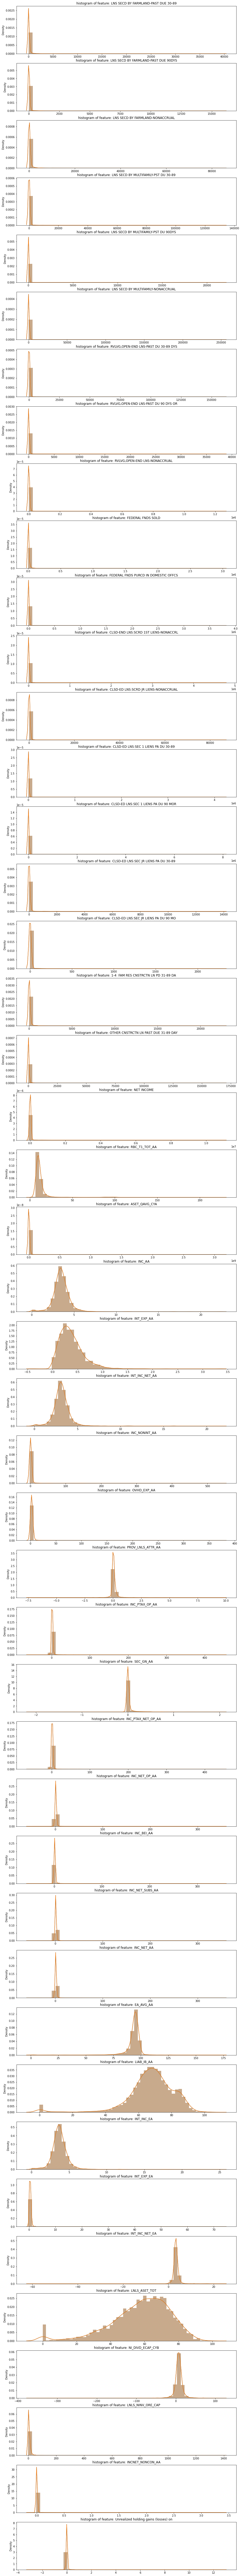

In [11]:
# Visualize each feature's distribution
def get_histograms(df, size):
    features = df.columns

    plt.figure(figsize=(15,size*4))
    gs = gridspec.GridSpec(size, 1)
    for i, cn in enumerate(df[features]):
        ax = plt.subplot(gs[i])
        sns.distplot(df[cn], bins=50)
        sns.distplot(df[cn], bins=50)
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(cn))
    plt.show()

get_histograms(processed_feature_df, 45)

##### Notes:
* A majority of features in the dataset are skewed
* Some of the features are multimodal
**The dataset needs to be transformed to deal with these issues*

<AxesSubplot:title={'center':'Peer Group Class Frequencies'}, xlabel='Peer Group', ylabel='Count'>

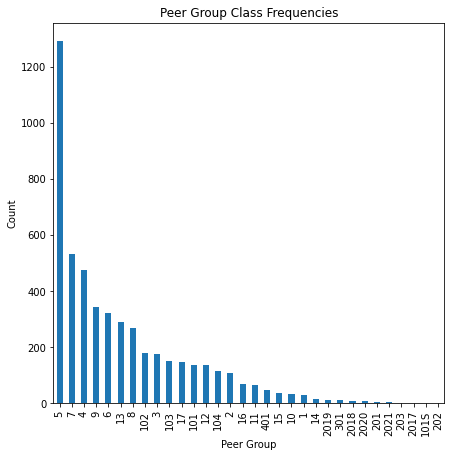

In [12]:
# Visualize the distribution of the target variable with a bar chart
counts_df = target_df.value_counts()
fig, ax = plt.subplots(figsize=(7,7))
plt.title("Peer Group Class Frequencies")
plt.xlabel("Peer Group")
plt.ylabel("Count")
counts_df.plot.bar(ax=ax)

##### Notes:
* Peer Group is severely imbalanced
**The dataset needs to be oversampled to deal with this issue*

#### 5. Oversampling
* Due to the importance of having a balanced dataset in classification algorithms, we must create synthetic samples for the underrepresented Peer Groups using Synthetic Minority Oversampling Technique (SMOTE).
* The goal is to use SMOTE to generate extra examples of every minority Peer Group class until they have equal sample sizes to the largest Peer Group class.

In [13]:
# Oversample the targets so that class size is equal
def get_oversample(feature_df, target_df):
    # Function to remove all rows from the dataset that are
    # labeled with a Peer Group that occurs fewer than 6 times
    # Note: SMOTE requires at least 6 occurrences of each class
    #       to conduct the oversampling process
    def remove_rare_targets(feature_df, target_df):
        # Merge dataframes to start
        merged_df = feature_df.join(target_df)
        
        # Get a series containing an aggregation of each Peer Group and its count
        target_series = merged_df['Peer Group'].value_counts().sort_values(ascending = True)
        
        # Compile a list of all Peer Groups with a count less than 6
        classes_to_drop = []
        for cur_class, count in target_series.iteritems():
            if count < 6:
                classes_to_drop.append(cur_class)
        
        # Remove list of rare classes from merged dataframe
        rares_removed_merged_df = merged_df[~merged_df['Peer Group'].isin(classes_to_drop)]
        
        # Split the data into a feature and target dataframe
        trimmed_target_df = rares_removed_merged_df['Peer Group']
        trimmed_feature_df = rares_removed_merged_df.drop('Peer Group', axis = 1)
        
        return trimmed_feature_df, trimmed_target_df

    trimmed_feature_df, trimmed_target_df = remove_rare_targets(feature_df, target_df)    
        
    oversample = SMOTE()
    oversampled_feature_df, oversampled_target_df = oversample.fit_resample(trimmed_feature_df, trimmed_target_df)
    return oversampled_feature_df, oversampled_target_df

oversampled_feature_df, oversampled_target_df = get_oversample(processed_feature_df, target_df)
print("Original shape:\t\tfeature - {}\ttarget - {}\nOversampled shape:\tfeature - {}\ttarget - {}".format(
        processed_feature_df.shape, target_df.shape, oversampled_feature_df.shape, oversampled_target_df.shape))

Original shape:		feature - (5030, 45)	target - (5030,)
Oversampled shape:	feature - (36176, 45)	target - (36176,)


#### 6. Feature Selection
* Having many features in a dataset causes adverse effects on a classification model due to an overwhelming amount of noise
    * Noise - data within a dataset that is of lesser importance, often confuses models and leads to underfitting
* Use Chi-Square to compare each feature to the target and keep the highest performing features
    * Chi-Square - used in statistics to test for independence between two variables. In our case, the Chi-Square formula will result in a high score for a feature if it is more dependent upon the target variable. 

In [14]:
# Function to implement feature selection using Chi Squared
# tests on each feature vs. the target to determine the 
# optimal subset of features
def select_features(feature_df):
    # Instantiate Chi-Square Model, use k ~ 1/3 of total features
    sel_chi2 = SelectKBest(chi2, k = 15)
    # Fit the model to the dataset, running chi-square test comparing each feature to the target
    sel_chi2.fit_transform(abs(oversampled_feature_df), oversampled_target_df)
    # Return subset of dataframe that is restricted to only the best 15 features
    subset = list(sel_chi2.get_feature_names_out())
    print('List of columns: {}'.format(subset))
    return feature_df[subset]

feature_selection_df = select_features(oversampled_feature_df)
feature_selection_df.shape

List of columns: ['LNS SECD BY FARMLAND-NONACCRUAL', 'LNS SECD BY MULTIFAMILY-PST DU 30-89', 'LNS SECD BY MULTIFAMILY-NONACCRUAL', 'RVLVG,OPEN-END LNS-PAST DU 30-89 DYS', 'RVLVG,OPEN-END LNS-PAST DU 90 DYS OR', 'RVLVG,OPEN-END LNS-NONACCRUAL', 'FEDERAL FNDS SOLD', 'FEDERAL FNDS PURCD IN DOMESTIC OFFCS', 'CLSD-END LNS:SCRD 1ST LIENS-NONACCRL', 'CLSD-ED LNS:SCRD JR LIENS-NONACCRUAL', 'CLSD-ED LNS:SEC 1 LIENS PA DU 30-89', 'CLSD-ED LNS:SEC 1 LIENS PA DU 90 MOR', 'OTHER CNSTRCTN LN PAST DUE 31-89 DAY', 'NET INCOME', 'ASET_QAVG_CYA']


(36176, 15)

#### 7. Transformation
* The distribution of our dataset is highly skewed and needs to be addressed
* To properly manage the data before ML modeling implement a Quantile Transformer
    * Quantile Transfomer - a nonlinear transformer that normalizes the distribution by shrinking the distance between outliers and inliers within a dataset

In [15]:
# Function to transform the features in the data set
def transform_data(feature_df, target_df):
    # Instantiate the Quantile Transformer
    transformer = QuantileTransformer()
    # Transform each feature independently to fit in a normal distribution
    transformed_df = transformer.fit_transform(feature_df, target_df)
    return transformed_df

transformed_feature_df = transform_data(feature_selection_df, oversampled_target_df)

#### 8. Model Testing
* Due to the size of the dataset after oversampling we will be testing with tree models
    * Tree models perform efficiently with high volumes of data, training/predicting at a fast rate
* Start with a Decision Tree Classifier for its explainability and use its results as a baseline
    * A Decision Tree Classifier starts with all the data at the root node, and continually answers Yes/No questions about the data until it reaches a pure node (a leaf) with only one possible target variable as its prediction.
* Next, test a variation of a Decision Tree, called a Random Forest Classifier
    * Random Forest is an ensemble model that uses the concepts of bootstrapping and bagging to increase accuracy and reduce overfitting by utilizing many decision trees in unison. Each decision tree in the Random Forest is decorrelated by forcing their splits (their Yes/No decisions) to occur with random subsets of the features (bootstrapping), in turn creating unique decision trees that follow different paths to make their predictions. Every tree in the forest has its prediction tabulated and the majority vote wins.
* Evaluate the success of each model using Sklearn's Repeated Stratified KFolds and Cross Validation Score


In [16]:
# Function to evaluate a ML model using KFolds and Cross
# Validation Score to calculate average Accuracy score 
def evaluate_model(feature_df, target_df, model, name):
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
    # Evaluate model
    scores = cross_val_score(model, feature_df, target_df, scoring = 'accuracy', cv = cv, n_jobs = -1)
    print('Average Accuracy Score for {}: {}'.format(name, np.mean(scores)))

# Instantiate models
dt = DecisionTreeClassifier() # Use Decision Tree Classifier as baseline to compare against
rf = RandomForestClassifier() # Ensemble model that enhances Decision Tree Classifier

# Determine accuracy of models 
evaluate_model(transformed_feature_df, oversampled_target_df, dt, 'Decision Tree Classifier')
evaluate_model(transformed_feature_df, oversampled_target_df, rf, 'Random Forest Classifier')

Average Accuracy Score for Decision Tree Classifier: 0.8653526220799047
Average Accuracy Score for Random Forest Classifier: 0.9178276767382724


#### 9. Modeling
* Both models performed very well during the evaluation process, with even the baseline Decision Tree Classifier hitting 86.5% accuracy
* The Random Forest Classifier performed ~5% better with an average accuracy score of 91.8%
* To create our model for predicting a bank's Peer Group, use the Random Forest Classifier, and split the dataset into training and testing partitions

In [17]:
# Split the dataframes into training and validation sets
X_train, X_validation, Y_train, Y_validation = train_test_split(transformed_feature_df, oversampled_target_df, test_size=0.3, random_state=1)

# Fit the Random Forest Classifier to the training data 
rf.fit(X_train, Y_train)

# Test the model on the validation data
score = rf.score(X_validation, Y_validation)

# Predict a Peer Group for each row of the validation set 
predictions = rf.predict(X_validation)
print('Accuracy Score for Random Forest using Train Test Split (70-30): {}'.format(score))

Accuracy Score for Random Forest using Train Test Split (70-30): 0.9086888417948954


#### 10. Model Evaluation
* Evaluating the success of the Random Forest Classifier is done by comparing our predictions with the corresponding set of true Peer Groups
* To highlight which classes within the Peer Groups were predicted better than others, create:
    * A confusion matrix
        * Yellow/Light Green appearing along the diagonal is a strong indicator of a high performing multiclass classifier 
    * A classification report that indicates each class within Peer Group, and its precision/recall/f1-score/accuracy/support
        * The weighted and macro average score is 91% across the board for precision/recall/f1-score

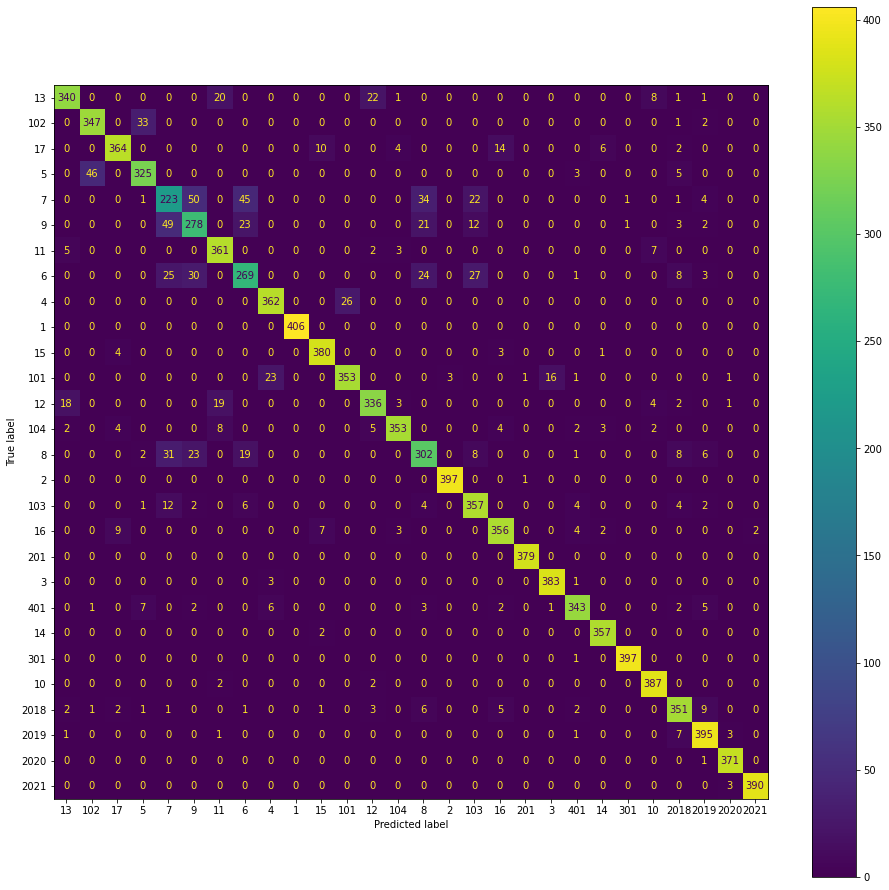

In [18]:
# Get unique instances of Peer Group
peer_groups = oversampled_target_df.unique()
# Create Confusion Matrix using our predictions and validation data
conf_matrix = confusion_matrix(Y_validation, predictions, labels=peer_groups)

# Visualize the Confusion Matrix
cmp = ConfusionMatrixDisplay(conf_matrix, display_labels=peer_groups)
fig, ax = plt.subplots(figsize=(16,16))
cmp.plot(ax=ax)

In [19]:
# Create table to show Precision/Recall/F1-Score and their Macro/Weighted Averages
print(classification_report(Y_validation, predictions, target_names=peer_groups))

              precision    recall  f1-score   support

          13       1.00      1.00      1.00       406
         102       0.95      0.99      0.97       391
          17       0.93      0.89      0.91       398
           5       0.88      0.91      0.89       383
           7       0.84      0.91      0.87       392
           9       0.96      0.92      0.94       383
          11       0.88      0.96      0.92       378
           6       0.91      0.88      0.89       383
           4       0.92      0.87      0.89       393
           1       0.97      0.99      0.98       359
          15       0.95      0.98      0.96       388
         101       0.93      0.93      0.93       383
          12       0.95      0.91      0.93       400
         104       0.99      1.00      0.99       398
           8       0.99      1.00      1.00       379
           2       0.89      0.91      0.90       385
         103       0.92      0.97      0.94       408
          16       0.98    

## Conclusion

The Bank Classification problem is solvable using the KPIs in the FDIC data dump. Random Forest Classifier proved to be a strong choice of model, boasting both macro and weighted average precision/recall/f-1 scores of 91%. A key part to the success of this model was oversampling the minority classes of the target variable Peer Group. By using SMOTE to oversample the imbalanced dataset, every class within Peer Group was given a fighting chance to be considered by the model. In my next iterations I would implement feature engineering, advanced data cleaning techniques, and hyperparameter tuning. That being said, I am highly satisfied with the results of this classification model and look forward to tackling more problems in this domain.